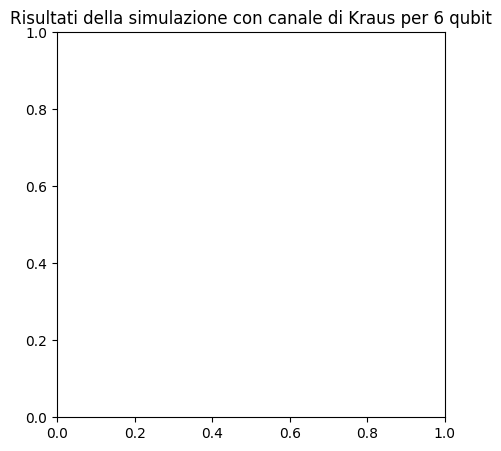

┌─────────┐                                   ┌────────┐┌─┐               
q_0: ┤ Rx(0.2) ├──■─────────■──────────────────────┤0       ├┤M├───────────────
     └──┬───┬──┘┌─┴─┐     ┌─┴─┐                    │        │└╥┘┌─┐            
q_1: ───┤ H ├───┤ X ├──■──┤ X ├──■─────────────────┤1       ├─╫─┤M├────────────
        └───┘   └───┘┌─┴─┐└───┘┌─┴─┐               │        │ ║ └╥┘┌─┐         
q_2: ────────────────┤ X ├──■──┤ X ├──■────────────┤2       ├─╫──╫─┤M├─────────
                     └───┘┌─┴─┐└───┘┌─┴─┐          │  kraus │ ║  ║ └╥┘┌─┐      
q_3: ─────────────────────┤ X ├──■──┤ X ├──■───────┤3       ├─╫──╫──╫─┤M├──────
                          └───┘┌─┴─┐└───┘┌─┴─┐     │        │ ║  ║  ║ └╥┘┌─┐   
q_4: ──────────────────────────┤ X ├──■──┤ X ├──■──┤4       ├─╫──╫──╫──╫─┤M├───
                               └───┘┌─┴─┐└───┘┌─┴─┐│        │ ║  ║  ║  ║ └╥┘┌─┐
q_5: ───────────────────────────────┤ X ├─────┤ X ├┤5       ├─╫──╫──╫──╫──╫─┤M├
                                    └───┘     └───┘└────────┘ ║  ║  ║  ║  ║ └╥┘
c: 6/═════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
                                                              0  1  2  3  4  5

In [1]:


from qiskit_aer import Aer
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, Kraus, SuperOp
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer.noise import QuantumError, NoiseModel
from IPython.display import display, Latex

# Parametri
n = 6 # Numero di qubit
theta = 0.2
shots = 10000  # Numero di esecuzioni

def tensor_n(matrix, n):
    """
    Costruisce il prodotto tensoriale di una matrice 'matrix' ripetuto n volte.

    Args:
        matrix (np.ndarray): Matrice 2x2.
        n (int): Numero di ripetizioni (numero di qubit).

    Returns:
        np.ndarray: Matrice 2^n x 2^n ottenuta come prodotto tensoriale.
    """
    result = np.array([[1.0]])
    for _ in range(n):
        result = np.kron(result, matrix)
    return result

# Parametri
p = 0.3            # Probabilità di applicare l'operatore di Kraus

# Matrice iniziale 2x2 (ad esempio, il gate Pauli X)
A = np.array([[0, 1],
              [1, 0]])

# Costruiamo l'operatore su n qubit come prodotto tensoriale di A
A_n = tensor_n(A, n)
I_n = np.eye(2**n)

# Definizione dei Kraus operatori:
# - Con probabilità (1-p) il canale lascia lo stato invariato (identità)
# - Con probabilità p viene applicato l'operatore A su tutti i qubit
K0 = np.sqrt(1 - p) * I_n
K1 = np.sqrt(p) * A_n

# Creiamo il canale di Kraus a partire dai due operatori
kraus_channel = Kraus([K0, K1])

# Creazione del circuito quantistico
qc = QuantumCircuit(n, n)
qc.rx(theta, 0)
qc.h(1)
qc.cx(0, 1)
for i in range(n - 2):
    qc.cx(i+1, i+2)
    qc.cx(i, i+1)


qc.cx(n-2, n-1)
qc.append(kraus_channel, list(range(n)))

# Creazione della matrice densità iniziale
rho = DensityMatrix.from_instruction(qc)



# Misura dei qubit
qc.measure(range(n), range(n))

# Simulazione senza rumore (poiché stiamo già simulando il rumore attraverso Kraus)
simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc, simulator)  # Ottimizzazione per il simulatore
result = simulator.run(qc, shots=shots).result()  # Esegui la simulazione

# Ottieni i conteggi dei risultati
counts = result.get_counts()

# Plot dei risultati
plt.figure(figsize=(5, 5))
plot_histogram(counts, color='royalblue')
plt.title(f"Risultati della simulazione con canale di Kraus per {n} qubit")
plt.show()

# Visualizzazione del circuito
qc.draw()

In [11]:
 from qiskit_aer.noise import QuantumError, NoiseModel

# 1. Input: numero di qubit e probabilità di rumore
n = 2
p = 0.2

# 2. Genera l'osservabile H
h = 9 / n
d = 2 ** n  # dimensione dello spazio degli stati
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

H_mat = np.zeros((d, d))
for k in range(0, n - 1, 2):
    op = 1
    for qubit in range(n):
        if qubit == k or qubit == k + 1:
            op = np.kron(op, Z)
        else:
            op = np.kron(op, I)
    H_mat += op
H_mat = h * H_mat
print("Osservabile H generato:\n", H_mat)

# 3. Creazione del circuito ansatz semplice
theta = 0.3
qc = QuantumCircuit(n)
for i in range(n):
    qc.rx(theta, i)
for i in range(n - 1):
    qc.cx(i, i + 1)

# 4. Definizione del canale di rumore personalizzato
GHZ = np.zeros((d, 1), dtype=complex)
GHZ[0] = 1 / np.sqrt(2)
GHZ[-1] = 1 / np.sqrt(2)

K1 = np.sqrt(1 - p) * np.eye(d)
K2_list = []
for i in range(d):
    ket_i = np.zeros((d, 1), dtype=complex)
    ket_i[i, 0] = 1.0
    K2 = np.sqrt(p / d) * np.dot(GHZ, ket_i.conj().T)
    K2_list.append(K2)
kraus_ops = [K1] + K2_list

noise_error = QuantumError(kraus_ops)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(noise_error, ['id'])

for i in range(n):
    qc.id(i)

print("\nCircuito ansatz con rumore:")
print(qc.draw())

# 5. Simulazione del circuito con il noise model
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, noise_model=noise_model, shots=1024, parameter_binds=[{theta: 0.5}])
result = job.result()
counts = result.get_counts(qc)
print("\nRisultati della simulazione (counts):", counts)

# (Opzionale) Simulazione dello statevector finale con il noise model
backend_sv = Aer.get_backend('statevector_simulator')
job_sv = execute(qc, backend_sv, noise_model=noise_model, parameter_binds=[{theta: 0.5}])
result_sv = job_sv.result()
statevector = result_sv.get_statevector(qc)
print("\nStatevector finale (con rumore):\n", statevector)


Osservabile H generato:
 [[ 4.5  0.   0.   0. ]
 [ 0.  -4.5  0.   0. ]
 [ 0.   0.  -4.5  0. ]
 [ 0.   0.   0.   4.5]]


NoiseError: "Invalid type of input is found around '[[0.89442719 0.         0.         0.        ]\n [0.         0.89442719 0.         0.        ]\n [0.         0.         0.89442719 0.        ]\n [0.         0.         0.         0.89442719]]'"